In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mvtec-ad/readme.txt
/kaggle/input/mvtec-ad/license.txt
/kaggle/input/mvtec-ad/wood/readme.txt
/kaggle/input/mvtec-ad/wood/license.txt
/kaggle/input/mvtec-ad/wood/ground_truth/hole/000_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/003_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/004_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/005_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/001_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/006_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/008_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/007_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/002_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/009_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/liquid/000_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/liquid/003_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/liquid/004_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/liquid/005_mask.png
/kaggle/input/mvte

In [24]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim

In [25]:
#Let's take screw dataset
dataset_path = '/kaggle/input/mvtec-ad/screw'
train_path = '/kaggle/input/mvtec-ad/screw/train'
test_path = '/kaggle/input/mvtec-ad/screw/test'

In [44]:
#Image processing
transform_func = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_func = transforms.Compose([
transforms.Resize((128,128)),
transforms.ToTensor()
])

In [46]:
#load dataset
train_dataset = ImageFolder(root=train_path,transform=transform_func)
test_dataset = ImageFolder(root=test_path,transform=test_transform_func)

In [47]:
#loaders 
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [58]:
image,label = train_dataset[101]

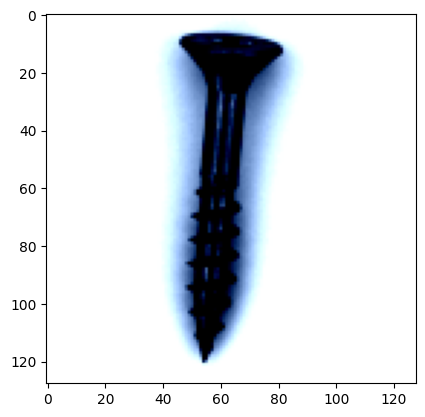

In [59]:
plt.imshow(image.permute(1,2,0).numpy()) #permute is torch's function. Torch (C,H,W) -> Matplotlib (H,W,C)

In [60]:
#Creating an AE model

class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        #Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2)
        )
        #Bottleneck
        self.bottleneck = nn.Conv2d(32,64,3,1,1)
        self.decoder = nn.Sequential(
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16,3,3,1,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [62]:
model = AE().to(device)

In [63]:
model

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.2, inplace=False)
  )
  (bottleneck): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [64]:
#hyperparams
optimizer = optim.Adam(model.parameters(),lr=1e-03)
loss_fn = nn.L1Loss()
epochs = 10

In [65]:
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images,_ in train_loader:
        images = images.to(device)
        pred = model(images)
        loss = loss_fn(pred,images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    avg_loss = train_loss/len(train_loader)
    print(f'Epoch: {epoch} | Loss: {avg_loss}')
        

Epoch: 0 | Loss: 0.7599393546581268
Epoch: 1 | Loss: 0.6050094246864319
Epoch: 2 | Loss: 0.54139144718647
Epoch: 3 | Loss: 0.5288431316614151
Epoch: 4 | Loss: 0.5240873277187348
Epoch: 5 | Loss: 0.5232164025306701
Epoch: 6 | Loss: 0.5161698520183563
Epoch: 7 | Loss: 0.51158207654953
Epoch: 8 | Loss: 0.5084117859601974
Epoch: 9 | Loss: 0.504032763838768


In [66]:
#Evaluation
model.eval()

test_images, reconstructed_images,reconstruction_errors = [],[],[]

with torch.no_grad():
    for images,_ in test_loader:
        images = images.to(device)
        pred = model(images)
        test_images.append(images.cpu())
        reconstructed_images.append(pred.cpu())
        reconstruction_errors.append(((images-pred)**2).mean(dim = (1,2,3)).cpu().numpy())

#combine results 
test_images = torch.cat(test_images)
reconstructed_images = torch.cat(reconstructed_images)
reconstruction_errors = np.concatenate(reconstruction_errors)

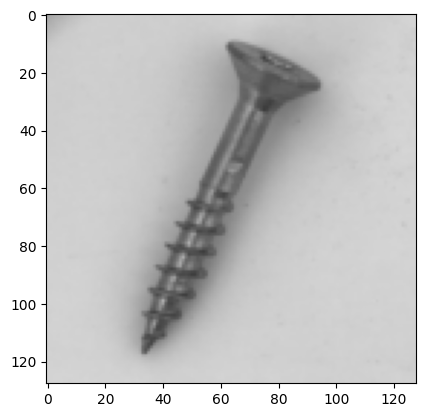

In [67]:
plt.imshow(test_images[100].permute(1,2,0).cpu().numpy())


0.06439921


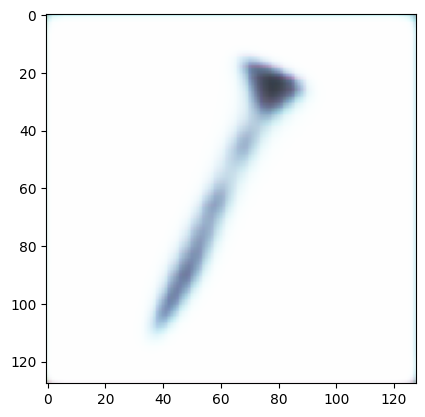

In [68]:
plt.imshow(reconstructed_images[100].permute(1,2,0).cpu().numpy())
print(reconstruction_errors[100])


In [ ]:

error
# Visualize results
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(5):
    # Original
    axes[0, i].imshow(test_images[i].permute(1, 2, 0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Reconstructed
    axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")
plt.show()

# Display reconstruction errors
print("Reconstruction Errors:", reconstruction_errors[:10])

In [ ]:
threshold = np.percentile(reconstruction_errors, 95)  # Set threshold (e.g., 95th percentile)
anomalies = reconstruction_errors > threshold
print("Number of anomalies detected:", anomalies.sum())

In [41]:
test_image_path = '/kaggle/input/mvtec-ad/metal_nut/train/good/000.png'

In [ ]:
from PIL import Image

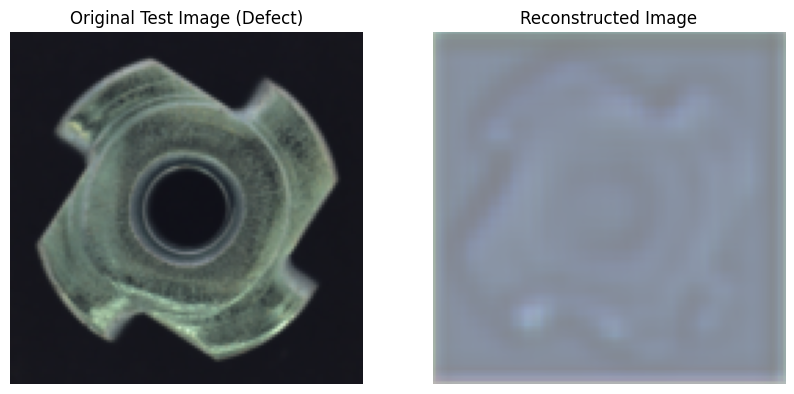

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [69]:
# Load and preprocess the test image
def preprocess_image(image_path, image_size=(128, 128)):  # Ensure the size matches the model input
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1] range
    ])
    image = Image.open(image_path).convert("RGB")  # Open and ensure it's in RGB format
    return transform(image).unsqueeze(0)  # Add batch dimension

# Load the test image
test_image = preprocess_image(test_image_path)

# Pass the test image through the autoencoder
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    reconstructed_image = model(test_image.to(device))

# Remove the batch dimension for visualization
test_image = test_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_image = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# De-normalize (if normalization was applied during preprocessing)
test_image = (test_image * 0.5) + 0.5  # Reverse normalization to [0, 1]
reconstructed_image = (reconstructed_image * 0.5) + 0.5

# Visualize the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Original Test Image (Defect)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()
# Compute the reconstruction error (Mean Squared Error)
def compute_reconstruction_error(original, reconstructed):
    # Compute the MSE (Mean Squared Error) between the original and reconstructed image
    return torch.mean((original - reconstructed) ** 2)

# Convert images to tensors for error calculation
test_image_tensor = test_image.squeeze(0)
reconstructed_image_tensor = reconstructed_image.squeeze(0)

# Compute the MSE
reconstruction_error = compute_reconstruction_error(test_image_tensor, reconstructed_image_tensor)
print(f"Reconstruction Error: {reconstruction_error.item()}")

# Set a threshold for classification
threshold = 0.05  # This value can be adjusted based on your dataset

# Classify as defective or not based on the reconstruction error
if reconstruction_error.item() > threshold:
    print("The image is likely defective.")
else:
    print("The image is likely normal.")

Original test image shape: torch.Size([1, 3, 128, 128])
Reconstructed image shape: torch.Size([1, 3, 128, 128])


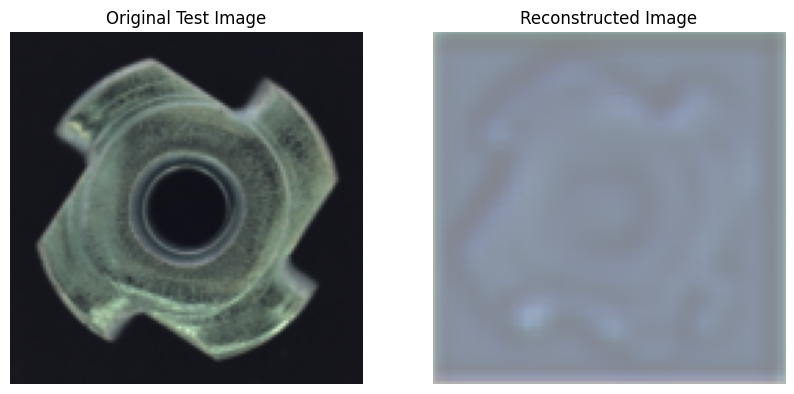

Reconstruction Error: 0.5616932511329651
The image is likely defective.


In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from torchvision import transforms

# Path to a test image (defect category)
test_image_path = "/kaggle/input/mvtec-ad/metal_nut/train/good/000.png"  # Replace with actual path

# Load and preprocess the test image
def preprocess_image(image_path, image_size=(128, 128)):  # Ensure the size matches the model input
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1] range
    ])
    image = Image.open(image_path).convert("RGB")  # Open and ensure it's in RGB format
    return transform(image).unsqueeze(0)  # Add batch dimension

# Load the test image
test_image = preprocess_image(test_image_path)

# Pass the test image through the autoencoder
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    reconstructed_image = model(test_image.to(device))

# Check the shapes of the tensors before squeezing
print(f"Original test image shape: {test_image.shape}")
print(f"Reconstructed image shape: {reconstructed_image.shape}")

# Ensure we only squeeze the batch dimension if it exists (i.e., batch size = 1)
if test_image.dim() == 4:  # Check if there is a batch dimension
    test_image_np = test_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
else:
    test_image_np = test_image.permute(1, 2, 0).cpu().numpy()

if reconstructed_image.dim() == 4:  # Check if there is a batch dimension
    reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
else:
    reconstructed_image_np = reconstructed_image.permute(1, 2, 0).cpu().numpy()

# De-normalize (if normalization was applied during preprocessing)
test_image_np = (test_image_np * 0.5) + 0.5  # Reverse normalization to [0, 1]
reconstructed_image_np = (reconstructed_image_np * 0.5) + 0.5

# Visualize the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image_np)
plt.title("Original Test Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np)
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()

# Compute the reconstruction error (Mean Squared Error)
def compute_reconstruction_error(original, reconstructed):
    # Compute the MSE (Mean Squared Error) between the original and reconstructed image
    return torch.mean((original - reconstructed) ** 2)

# Convert images to tensors for error calculation (remove batch dimension)
if test_image.dim() == 4:
    test_image_tensor = test_image.squeeze(0)
else:
    test_image_tensor = test_image

if reconstructed_image.dim() == 4:
    reconstructed_image_tensor = reconstructed_image.squeeze(0)
else:
    reconstructed_image_tensor = reconstructed_image

# Compute the MSE
reconstruction_error = compute_reconstruction_error(test_image_tensor.cpu(), reconstructed_image_tensor.cpu())
print(f"Reconstruction Error: {reconstruction_error.item()}")

# Set a threshold for classification
threshold = 0.5  # This value can be adjusted based on your dataset

# Classify as defective or not based on the reconstruction error
if reconstruction_error.item() > threshold:
    print("The image is likely defective.")
else:
    print("The image is likely normal.")
